In [294]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.base import BaseEstimator
import gensim 
from nltk.corpus import stopwords
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from gensim import corpora

plt.style.use('seaborn-whitegrid')

This data originally came from Crowdflower's [Data for Everyone library](http://www.crowdflower.com/data-for-everyone).

As the original source says,

> We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked which candidate was mentioned, and what the sentiment was for a given tweet. 

In [4]:
# load dataset 
tweets = pd.read_csv('input/Sentiment.csv', parse_dates=['tweet_created'])
tweets.sample(5)

,Unnamed: 0,id,candidate,sentiment,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
10999,10999,11000,Jeb Bush,Neutral,hobbsislander,153,RT @RWSurferGirl: Fox is cherry picking the ca...,NaN,2015-08-06 19:44:52-07:00,629483316140482561,Cul de Sac off Copperhead Rd,NaN
3430,3430,3431,No candidate mentioned,Neutral,LambasixX,0,Countries in Africa RT' &amp; DL' #Internatio...,NaN,2015-08-07 09:18:50-07:00,629688159757058048,DOPECITY HD,London
7083,7083,7084,No candidate mentioned,Negative,baronvonparker,1,#GOPDebate was the most watched primary debate...,NaN,2015-08-07 08:10:41-07:00,629671005221482496,NaN,Central Time (US & Canada)
11095,11095,11096,No candidate mentioned,Negative,Mina001,120,RT @RWSurferGirl: Why doesn't Chris Wallace as...,NaN,2015-08-06 19:43:24-07:00,629482947964309504,USA,Central Time (US & Canada)
13399,13399,13400,Jeb Bush,Negative,gatmanuk1,153,RT @RWSurferGirl: Fox is cherry picking the ca...,NaN,2015-08-06 19:05:12-07:00,629473332728057857,World/Net CitiZen,Nairobi


In [5]:
print(f"dataset contains {tweets.shape[0]} tweets and {tweets.shape[1]} predictor variables.")

dataset contains 13871 tweets and 12 predictor variables.


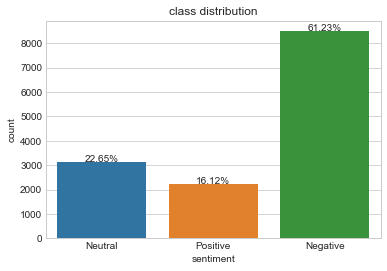

In [6]:
plt.figure()
ax = plt.axes()
sns.countplot(tweets.sentiment)

total_tweets = len(tweets)
plt.title('class distribution')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+20,
            f'{int(height)/total_tweets:.2%}',
            ha="center", fontsize=10)
    
plt.show()

In [7]:
contingency_table = pd.crosstab(tweets.candidate, tweets.sentiment)
contingency_table['negative_proportion'] = contingency_table.Negative/contingency_table.sum(axis=1)
contingency_table

sentiment,Negative,Neutral,Positive,negative_proportion
candidate,,,,
Ben Carson,186,54,164,0.460396
Chris Christie,218,42,33,0.744027
Donald Trump,1758,446,609,0.624956
Jeb Bush,589,72,44,0.835461
John Kasich,82,47,113,0.338843
Marco Rubio,105,51,119,0.381818
Mike Huckabee,237,83,73,0.603053
No candidate mentioned,4724,2087,680,0.630623
Rand Paul,148,60,55,0.562738


The candidate `Donald Trump` has the highest number of negative tweets. However, if we look at the total number of tweet per candidate we can see that `Jeb Bush` has almost 84% of the tweets mentionning him as negative.

**What kind of tweets are the most retweeted?**

In [8]:
tweets.groupby('sentiment').sum()['retweet_count']

sentiment
Negative    419335.0
Neutral     117243.0
Positive     98760.0
Name: retweet_count, dtype: float64

Negative tweets are more than 4 times retweeted than positive tweets. 

**Who are the most retweeted candidates?**

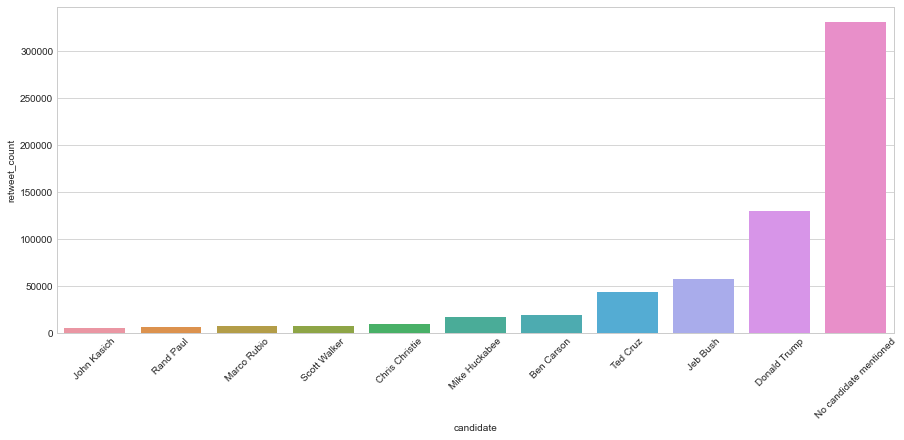

In [9]:
most_rt_candidates = tweets.groupby('candidate').sum()['retweet_count'].sort_values()
plt.figure(figsize=(15,6))
sns.barplot(most_rt_candidates.index, most_rt_candidates)
plt.xticks(rotation=45)
plt.show()

Let us have a look at the time variable `tweet_created`

In [10]:
start_date = tweets.tweet_created.sort_values().iloc[0]
end_date = tweets.tweet_created.sort_values().iloc[-1]
start_date, end_date, (end_date - start_date), start_date.day_name(), end_date.day_name()

(Timestamp('2015-08-06 17:44:53-0700', tz='pytz.FixedOffset(-420)'),
 Timestamp('2015-08-07 10:12:32-0700', tz='pytz.FixedOffset(-420)'),
 Timedelta('0 days 16:27:39'),
 'Thursday',
 'Friday')

We can conclude that the tweets recording lasted for 16hours and ~28 minute. The recodring started Thursday, august 2015 at 17:44 until friday, august 2015 at 10:12.

**How are tweets distributed accros the day? is there any time slot that has more tweets than others?**

In [11]:
tweets_ordered_bytime = tweets.sort_values(by='tweet_created')

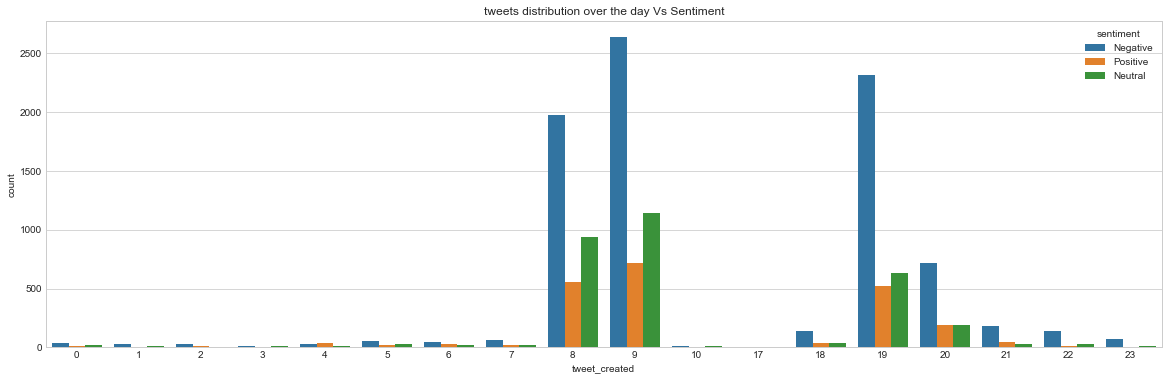

In [12]:
plt.figure(figsize=(20,6))
sns.countplot(tweets_ordered_bytime.tweet_created.dt.hour, hue=tweets_ordered_bytime.sentiment)
plt.title('tweets distribution over the day Vs Sentiment')
plt.show()

We might one to add a new predictor variable that stores the hour of the day or maybe categorigal variable with the following enumeration: morning, afternoon, evening, night

## Missing values

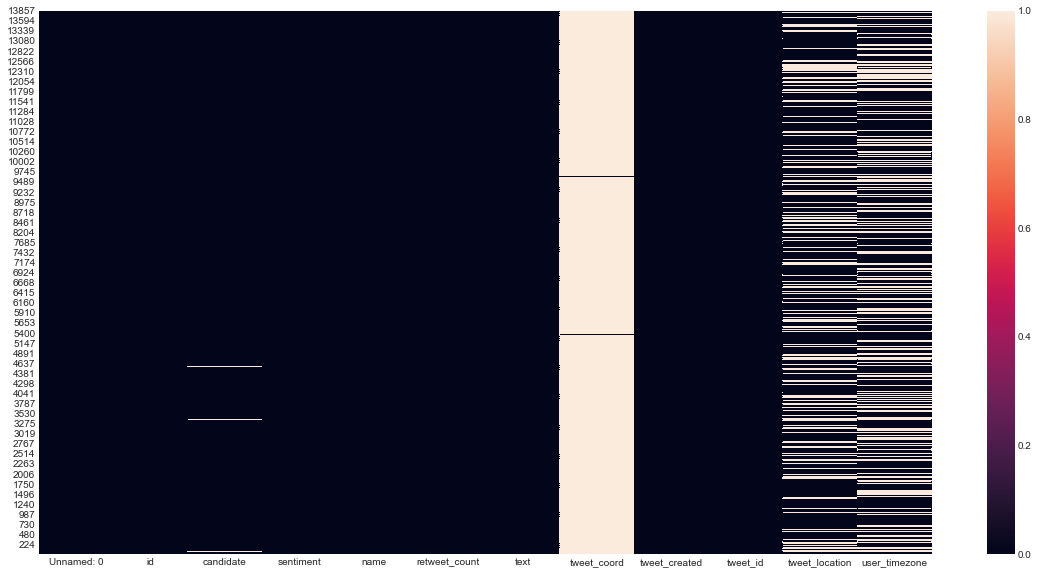

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(tweets_ordered_bytime.isna())
plt.show()

`Tweet_location` and `user_timezone` contain a lot of missing values.
- add new boolean is_nan + impuatation most freq ?

In [14]:
tweets.tweet_location.isna().sum()/len(tweets), tweets.user_timezone.isna().sum()/len(tweets)

(0.28202725109941607, 0.3174248431980391)

Tweet_location and user_timezone are composed of neary 30% of missing of values.

In [15]:
def is_feature_important(feature, target, alpha=.05):
    crosstable = pd.crosstab(target,feature) 
    chi2, p, dof, expected = stats.chi2_contingency(crosstable.values)
    
    return p < alpha

In [16]:
is_feature_important(tweets.user_timezone, tweets.sentiment), is_feature_important(tweets.tweet_location, tweets.sentiment)

(True, True)

- Tweet_location and user_timezone are correlated with the target variable accorind to kh2 test of independance.

## Tweet's text

Let's print some tweets and see how they look

In [ ]:
tweets.text.sample(2).to_list()

["RT @Nice1Parker: #GOPdebates where the bell doesn't mean a thing #dingdingding 😂",
 'RT @ckimbro927: Paul brilliantly got Christie to admit that he would violate the 4th Amendment. Of course, no one in that building cares. #…']

Before analyzing tweets some cleaning has to be performed:
- remove special caracters.
- remove links


In [62]:
def pre_process_tweets(tweet):
    tweet = tweet.replace('RT', '').replace('@', '').replace('#', '')
    
    # remove links
    tweet = re.sub(r'http[s]*\S+', '', tweet)
    
    tokens = word_tokenize(tweet)
    
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token.lower() for token in tokens]
    # no lemmatization or stemming since we are going to use pre-trained embeddings
    
    
    # delete stop words
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

tweets['tokens'] = tweets.text.apply(pre_process_tweets)

## Topic modeling

In [63]:
# Create dictionary
dictionary = corpora.Dictionary(tweets.tokens)
print(dictionary)

Dictionary(13630 unique tokens: ['change', 'climate', 'everyone', 'exactly', 'feel']...)


In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel

# Instantiate the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=False, analyzer=lambda x: x)

# Compute the TF-IDF
tf_idf = vectorizer.fit_transform(tweets['tokens'])

# Convert the TF-IDF to the needed input for Gensim
tf_idf_sklearn = Sparse2Corpus(tf_idf, documents_columns=False)

# Compute the LDA
lda2 = LdaModel(corpus=tf_idf_sklearn, id2word=dictionary, num_topics=3, passes=10)

# Print the main topics
pprint(lda2.print_topics())

[(0,
  '0.027*"oncoming" + 0.027*"leverage" + 0.024*"perspective" + 0.017*"trivia" '
  '+ 0.016*"shill" + 0.013*"unpredictability" + 0.010*"national" + '
  '0.009*"lnyhbt" + 0.009*"flush" + 0.008*"parisdennard"'),
 (1,
  '0.018*"leverage" + 0.015*"jpnet" + 0.012*"unpredictability" + '
  '0.011*"oncoming" + 0.011*"lorion" + 0.008*"parisdennard" + 0.008*"assure" + '
  '0.008*"essentially" + 0.008*"overdue" + 0.008*"jacksonville"'),
 (2,
  '0.015*"leverage" + 0.009*"unpredictability" + 0.007*"cqnow" + '
  '0.007*"goprealityshow" + 0.005*"lap" + 0.005*"nerdland" + '
  '0.004*"unfairworld" + 0.004*"outta" + 0.004*"jeebus" + '
  '0.004*"parisdennard"')]


In [81]:
# Import the modules
import pyLDAvis
import pyLDAvis.gensim

bow = [dictionary.doc2bow(token) for token in tweets.tokens]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda2, corpus=bow, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.076798  0.153505       1        1  46.811356
1     -0.107587 -0.137317       2        1  36.088097
0      0.184385 -0.016188       3        1  17.100548, topic_info=               Term         Freq        Total Category  logprob  loglift
10358      oncoming  1134.000000  1134.000000  Default  30.0000  30.0000
4546    perspective   539.000000   539.000000  Default  29.0000  29.0000
1612          jpnet   697.000000   697.000000  Default  28.0000  28.0000
8160         trivia   388.000000   388.000000  Default  27.0000  27.0000
9719          shill   392.000000   392.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
12500  parisdennard   185.716568   827.954834   Topic3  -4.7913   0.2713
9545      dragswolf   123.063187   213.136658   Topic3  -5.2028   1.2168
13159       angrily   114.525162   185.112106   Topic3  -5.2747   1.2859
13101        costco   119.420059   336.579193   Topic3  -5.2329   0.7299
422        donation   112.751762   398.719330   Topic3  -5.2903   0.5030

[176 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
11691      1  0.978772  aduanebrown
11691      2  0.020139  aduanebrown
3875       1  0.009645          age
3875       2  0.983757          age
13536      1  0.012968     aleister
...      ...       ...          ...
6781       1  0.699261         wink
6781       2  0.282680         wink
6781       3  0.017853         wink
11169      1  0.989490    wmcinally
11169      2  0.007496    wmcinally

[349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

It is not easy to intuitevely see what are the underlying topics from LDA results.

In [302]:
tweets_complexity = pd.DataFrame(tweets_cleaned)
tweets_complexity['tweet_len'] = tweets_cleaned.str.len()
tweets_complexity['num_words'] = tweets_cleaned.str.split().str.len()
tweets_complexity['nunique_words'] = tweets_cleaned.str.split().apply(set).str.len()
tweets_complexity['words_diversity'] = tweets_complexity['nunique_words'] / tweets_complexity['num_words'] 
tweets_complexity['sentiment'] = tweets.sentiment
tweets_complexity.sample(5)

,text,tweet_len,num_words,nunique_words,words_diversity,sentiment
826,BBCJonSopel: Listening to Donald Trump2016 yo...,112,18,18,1.000000,Negative
8530,RWSurferGirl: So megynkelly posed for adult p...,100,13,13,1.000000,Neutral
3124,Doesn't it bother anyone that the GOP is prima...,143,26,24,0.923077,Negative
8433,"larryelder: Trump should have said, ""Megyn, a...",136,22,22,1.000000,Negative
5113,Lol- I just realized there are people that are...,113,20,19,0.950000,Negative


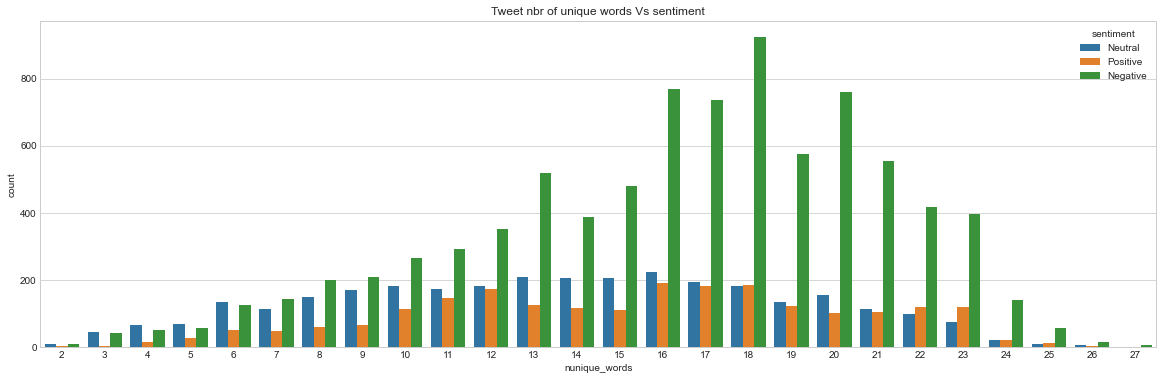

In [303]:
plt.figure(figsize=(20,6))
sns.countplot(tweets_complexity.nunique_words, hue=tweets_complexity.sentiment)
plt.title('Tweet nbr of unique words Vs sentiment')
plt.show()

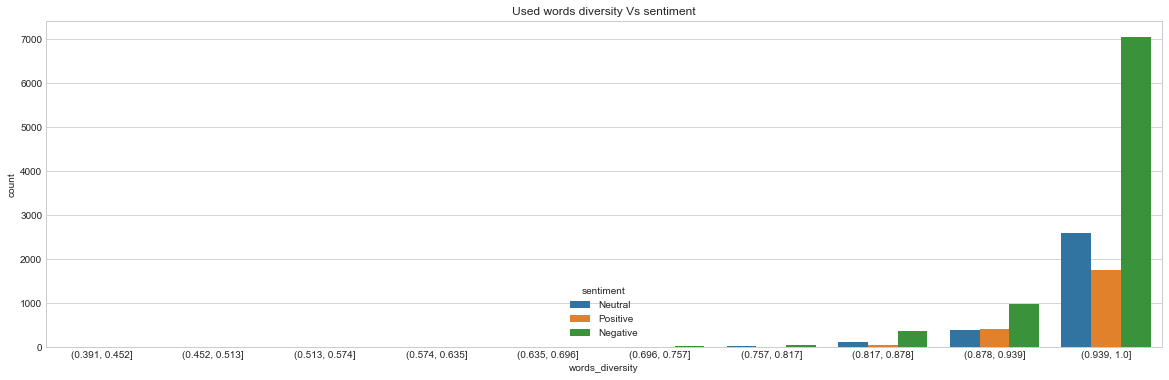

In [308]:

plt.figure(figsize=(20,6))
sns.countplot(pd.cut(tweets_complexity.words_diversity, 10), hue=tweets_complexity.sentiment)
plt.title('Used words diversity Vs sentiment')
plt.show()

## tweet_created

let's create four categories out of tweet_created.

- Noon: from 6:00 to 12:00 
- Afternoon: from 12:01 to 17:00
- Evening: from 17:01 to 20:00
- Night: from 20:01 to 5:59

In [10]:
def mapping_func(hour):
    if 6 < hour <= 12:
        return 'Noon'
    elif 12 < hour <= 17:
        return 'Afternoon'
    elif 17 < hour <= 20:
        return 'Evening' 
    else:
        return 'Night'
period_of_day = tweets.tweet_created.dt.hour.apply(mapping_func)

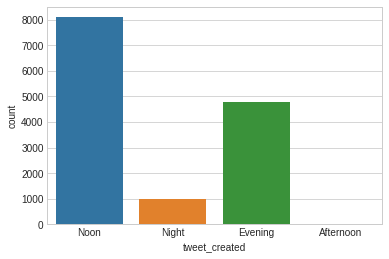

In [11]:
sns.countplot(period_of_day);

People tend to tweet more in the morning as well as in the evening before going to bed.

## Sentiment

Let's encode our classes into numerical values.

In [12]:

target_encoder = LabelEncoder()
y = pd.Series(target_encoder.fit_transform(tweets.sentiment))

As we saw in EDA ~30% of these two features is composed of missing values. Let's consider the missing value as another category therefore we will impute it -999.

Let's create two other feature, user_timezone_isna and tweet_location_isna which will hold a boolean value to indictate to the model the rows containing missing values respectively for user_timezone and tweet_location.

In [123]:
tweets['user_timezone_isna'] = tweets.user_timezone.isna().astype(int)
tweets['tweet_location_isna'] = tweets.tweet_location.isna().astype(int)
tweets['user_timezone'] = tweets.user_timezone.fillna(-999)
tweets['tweet_location'] = tweets.tweet_location.fillna(-999)

## Candidate

In [14]:
tweets.candidate.isna().sum()

96

In [15]:
tweets.candidate.value_counts()

No candidate mentioned    7491
Donald Trump              2813
Jeb Bush                   705
Ted Cruz                   637
Ben Carson                 404
Mike Huckabee              393
Chris Christie             293
Marco Rubio                275
Rand Paul                  263
Scott Walker               259
John Kasich                242
Name: candidate, dtype: int64

When a candidate is not mentionned, the tweet is put in 'No candidate mentioned'. Therefore, I will consider the missing candidate values to be part of 'No candidate mentioned' category.

In [122]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
tweets['candidate'] = imputer.fit_transform(tweets['candidate'].values.reshape(-1, 1))

## Data split

Our final dataset will be composed of the following features: user_timezone_isna, tweet_location_isna, user_timezone, tweet_location, text embeddings, retweet_count and candidate

In [235]:
boolean_features = ['user_timezone_isna', 'tweet_location_isna']
categorical_features = ['candidate', 'user_timezone', 'tweet_location']
numerical_features = ['retweet_count']
embeddings = ['text']

In [292]:
tweets[boolean_features+categorical_features+numerical_features+embeddings].sample(5)

,user_timezone_isna,tweet_location_isna,candidate,user_timezone,tweet_location,retweet_count,text
7371,0,1,Marco Rubio,Pacific Time (US & Canada),-999,0,"Rubio, Cruz and Carson were the top dawgs i..."
5398,0,0,No candidate mentioned,Eastern Time (US & Canada),New York City,0,#MegynKelly #GOPDebate After last night I won...
7443,1,1,No candidate mentioned,-999,-999,0,Jon Stewart America needs you! SMH at #GOPDeba...
1681,1,0,No candidate mentioned,-999,"Jacksonville, AL",126,"RT @AlexSamuelsx5: So, there's 45 minutes left..."
12183,0,0,No candidate mentioned,Pacific Time (US & Canada),"Newport Beach, California",120,Why doesn't Chris Wallace ask the other politi...


In [241]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(tweets[boolean_features+categorical_features+numerical_features+embeddings], y, test_size=.2,
                               stratify=y, random_state=SEED)

# Pipeline

For the categorical variable, I suggest that we count encode them. Basically we will replace each categorie by it's number of occurences.

In [285]:
stop_words = stopwords.words("english")
class Doc2Vec(BaseEstimator):

    def __init__(self, vector_size=50, min_count=2, epochs=40):        
        self.vector_size=vector_size
        self.min_count=min_count
        self.epochs=epochs
        
    def __pre_process(self, X, train_tag=True):
        X_tr = X.copy()
        X_tr = X_tr.text.str.replace('RT', '').str.replace('@', '').str.replace('#', '')

        # remove links
        X_tr = X_tr.str.replace(r'http[s]*\S+', '')

        X_tr = X_tr.apply(word_tokenize)

        X_tr = [[token.lower() for token in tokens if token.isalpha()] for tokens in X_tr]
        X_tr = [[token.lower() for token in tokens] for tokens in X_tr]
        # no lemmatization or stemming since we are going to use pre-trained embeddings


        # delete stop words
        X_tr = [[token.lower() for token in tokens if token not in stop_words] for tokens in X_tr]
        
        X_tag = []
        for i, doc in enumerate(X_tr):
                # For training data, add tags
                if train_tag:
                    X_tag.append(gensim.models.doc2vec.TaggedDocument(doc, [i]))
                else:
                    X_tag.append(doc)
        
        return list(X_tag)
    
    def fit(self, X_train, y=None):
        self.model = gensim.models.doc2vec.Doc2Vec(vector_size=self.vector_size, min_count=self.min_count, epochs=self.epochs)
        X_train_tag = self.__pre_process(X_train)
        self.model.build_vocab(X_train_tag) 
        self.model.train(X_train_tag, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        
        return self

    def transform(self, X):
        X_tr = self.__pre_process(X, train_tag=False)
        doc2vec_embeddings = np.array([self.model.infer_vector(doc) for doc in X_tr])
        
        return doc2vec_embeddings

class CountEncoder(BaseEstimator):

    def __init__(self, normalize=True):
        self.normalize = normalize

    def fit(self, X_train, y=None):
        self.__set_mapping(X_train)
        
        return self

    def transform(self, X):
        X_tr = X.copy()

        if type(X) != type(pd.DataFrame()): 
            raise ValueError(f'{type(X)} not supported')
        
        col_id = 0
        for col, serie in  X.iteritems():
            X_tr[col] = serie.map(self.mapping_list[col_id])
            col_id += 1
        
        return X_tr

    def __set_mapping(self, X):
        if type(X) != type(pd.DataFrame()):
            raise ValueError(f'{type(X)} not supported')

        self.mapping_list = []
        for col, serie in X.iteritems():
            if self.normalize:
                self.mapping_list.append((serie.value_counts()/serie.value_counts().max()).to_dict())
            else:
                self.mapping_list.append(serie.value_counts().to_dict())

In [287]:
static_params = {
    'objective': 'multiclass',
    'boosting_type': 'gbdt',
    'num_class': 3,
    'metric': 'multi_logloss',
    'max_depth': 5
}


feature_engineering = ColumnTransformer([('CountEncoder', CountEncoder(), categorical_features),
                                         ('doc2vec', Doc2Vec(), embeddings)],
                                         remainder='passthrough', verbose=0)

steps = [('feature_engineering', feature_engineering),
         ('model', lgb.LGBMClassifier(**static_params))
        ]

model = Pipeline(steps)
    


model.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('CountEncoder',
                                                  CountEncoder(),
                                                  ['candidate', 'user_timezone',
                                                   'tweet_location']),
                                                 ('doc2vec', Doc2Vec(),
                                                  ['text'])],
                                   verbose=0)),
                ('model',
                 LGBMClassifier(max_depth=5, metric='multi_logloss',
                                num_class=3, objective='multiclass'))])

In [291]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1699
           1       0.49      0.14      0.22       629
           2       0.62      0.29      0.40       447

    accuracy                           0.65      2775
   macro avg       0.59      0.46      0.47      2775
weighted avg       0.62      0.65      0.59      2775



In [290]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81      6794
           1       0.71      0.25      0.37      2513
           2       0.76      0.42      0.54      1789

    accuracy                           0.71     11096
   macro avg       0.72      0.54      0.57     11096
weighted avg       0.71      0.71      0.67     11096



The performance of the model is very bad, it could be that the the number of samples is not sufficient for the model to perform better. 

Options to consider in order to improve the model performance:

- perfrom a grid search to optimize hyperparamters
- create synthtic (SMOTE) tweets or scrappe more tweets and label them.
- feature engineering